In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
df = pd.read_csv('wine-reviews.csv', usecols=['country','description','points','price','variety','winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [7]:
df.isnull().sum()

country          63
description       0
points            0
price          8996
variety           1
winery            0
dtype: int64

In [11]:
df = df.dropna()

In [12]:
df.isnull().sum()

country        0
description    0
points         0
price          0
variety        0
winery         0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120915 entries, 1 to 129970
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120915 non-null  object 
 1   description  120915 non-null  object 
 2   points       120915 non-null  int64  
 3   price        120915 non-null  float64
 4   variety      120915 non-null  object 
 5   winery       120915 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.5+ MB


In [14]:
df.describe()

,points,price
count,120915.000000,120915.000000
mean,88.421726,35.368796
std,3.044954,41.031188
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


Text(0, 0.5, 'Count')

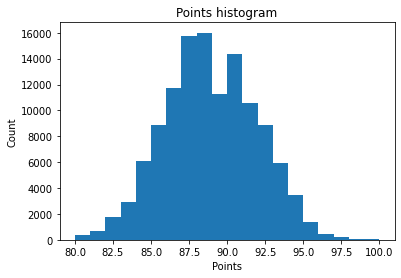

In [17]:
plt.hist(df.points, bins=20)
plt.title('Points histogram')
plt.xlabel('Points')
plt.ylabel('Count')

In [20]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description','label']]
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [22]:
train, val, test = np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [23]:
len(train), len(val), len(test)

(96732, 12091, 12092)

In [24]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df['description']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [25]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [40]:
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [42]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [44]:
history = model.fit(train_data,epochs=5,validation_data=val_data)

Epoch 1/5
95/95 [==============================] - 95s 981ms/step - loss: 0.6641 - accuracy: 0.5907 - val_loss: 0.5791 - val_accuracy: 0.7354
Epoch 2/5
95/95 [==============================] - 90s 943ms/step - loss: 0.5078 - accuracy: 0.7664 - val_loss: 0.3987 - val_accuracy: 0.8184
Epoch 3/5
95/95 [==============================] - 92s 970ms/step - loss: 0.4062 - accuracy: 0.8296 - val_loss: 0.3632 - val_accuracy: 0.8354
Epoch 4/5
95/95 [==============================] - 91s 955ms/step - loss: 0.3630 - accuracy: 0.8505 - val_loss: 0.3522 - val_accuracy: 0.8388
Epoch 5/5
95/95 [==============================] - 89s 938ms/step - loss: 0.3367 - accuracy: 0.8641 - val_loss: 0.3505 - val_accuracy: 0.8430


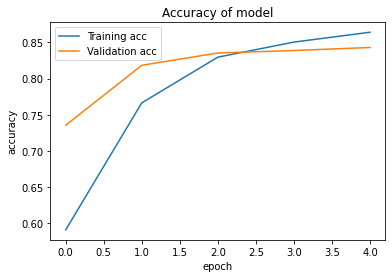

In [45]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title('Accuracy of model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

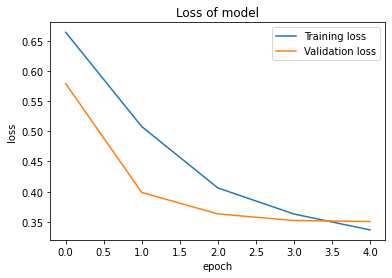

In [46]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [47]:
model.evaluate(test_data)

12/12 [==============================] - 2s 129ms/step - loss: 0.3666 - accuracy: 0.8344


[0.3665769398212433, 0.8343532681465149]